In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [36]:
 (train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [37]:
 num_classes = metadata.features['label'].num_classes
print(num_classes)
 

5


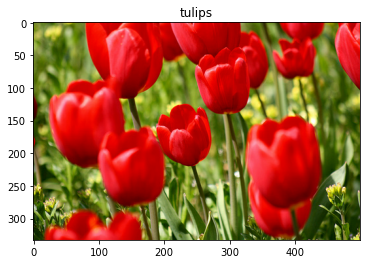

In [38]:
 get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))
 

In [39]:
 IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])
 

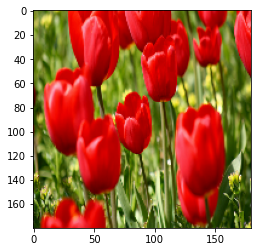

In [40]:
 result = resize_and_rescale(image)
_ = plt.imshow(result)
 

In [9]:
 print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
 

Min and max pixel values: 0.0 1.0


In [10]:
 data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
 

In [41]:
 data_augmentation2 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomZoom((-0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation((-0.2, 0.3), (-0.2, 0.3))
  #layers.experimental.preprocessing.RandomRotation(0.2),
])
 

In [42]:
 # Add the image to a batch
image = tf.expand_dims(image, 0)
 

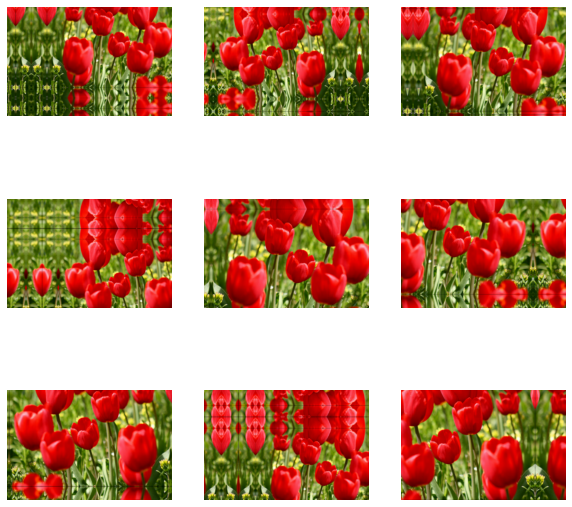

In [43]:
 plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation2(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [25]:
 # Add the image to a batch
image = tf.expand_dims(image, 0)
 

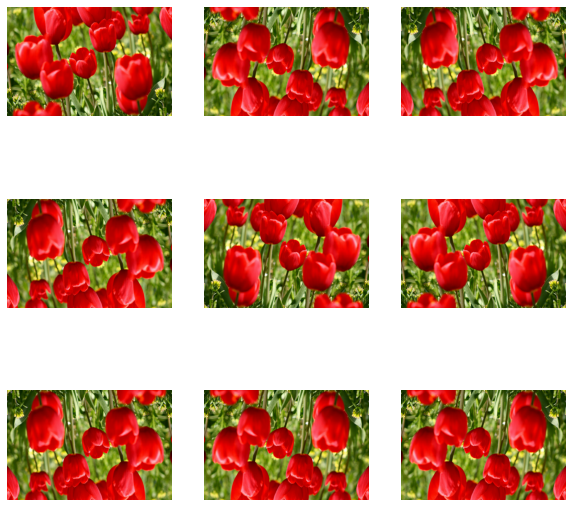

In [27]:
 plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation2(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
 

In [ ]:
#applying preprocessing layer to dataset 
aug_ds = train_ds.map(
lambda x, y: (resize_and_rescale(x, training=True), y))
 

In [ ]:
 batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)
 

In [ ]:
 train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)
 

In [ ]:
 model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
 

In [ ]:
 model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
 

In [ ]:
 epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
 

In [ ]:
 loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)
 